In [2]:
#Libraries
import pandas as pd
import numpy as np
#from datetime import dt
import math
import os

# Import code developed and functions
#from feature_extraction import preprocess, flatten, label, select_group

# Ignore warnings of appending dataframes
import warnings
warnings.simplefilter('ignore')

In [4]:
#path = 'C:\\Users\\mverd\\Desktop\\IMD\\ESSEX\\PredictingEmpathy\\rawdata\\'
#fname = 'test\\Participant0001.tsv'
path = ''
fname = 'C://Users/Ana/Desktop/Participant0001.tsv'
df_table = pd.read_table(path + fname, sep='\t',low_memory=False)


In [5]:
# Remove calibration points in recording
startPoints = df_table[df_table['Event']=='ImageStimulusStart'].index.values.astype(int)
endPoints = df_table[df_table['Event']=='ImageStimulusEnd'].index.values.astype(int)

# Store only image stimulus
df = pd.DataFrame()

for i in range(len(startPoints)):
    start = startPoints[i]
    end = endPoints[i]

    trial = df_table.iloc[start:end+1]
    df = pd.concat([df,trial])

# Columns we are keeping
df_col = ['Recording timestamp','Participant name',
            'Recording name','Recording duration',
            'Pupil diameter left','Pupil diameter right',
            'Gaze point X (MCSnorm)','Gaze point Y (MCSnorm)',
            'Eye movement type','Gaze event duration',
            'Fixation point X (MCSnorm)','Fixation point Y (MCSnorm)']

# Removing columns
df_features = df[df_col]

# Columns that need to be changed from object to float
objColumns = ['Pupil diameter left','Pupil diameter right','Gaze point X (MCSnorm)',
                'Gaze point Y (MCSnorm)','Fixation point X (MCSnorm)','Fixation point Y (MCSnorm)']

# Change (commas) to (decimals) and convert object to float64
for feature in objColumns:
    df_features[feature] = df_features[feature].str.replace(',','.').astype(float)

df_features

,Recording timestamp,Participant name,Recording name,Recording duration,Pupil diameter left,Pupil diameter right,Gaze point X (MCSnorm),Gaze point Y (MCSnorm),Eye movement type,Gaze event duration,Fixation point X (MCSnorm),Fixation point Y (MCSnorm)
3083,23419315,Participant0001,Recording1,83579,NaN,NaN,NaN,NaN,Fixation,117.0,0.5073,0.316
3084,23426120,Participant0001,Recording1,83579,NaN,NaN,0.5011,0.3203,Fixation,117.0,0.5073,0.316
3085,23434449,Participant0001,Recording1,83579,NaN,NaN,0.5016,0.3244,Fixation,117.0,0.5073,0.316
3086,23442782,Participant0001,Recording1,83579,3.21,3.14,0.5016,0.3202,Fixation,117.0,0.5073,0.316
3087,23451119,Participant0001,Recording1,83579,NaN,NaN,0.5079,0.3145,Fixation,117.0,0.5073,0.316
...,...,...,...,...,...,...,...,...,...,...,...,...
82494,43375993,Participant0001,Recording8,43548,NaN,NaN,NaN,NaN,EyesNotFound,922.0,NaN,NaN
82495,43384336,Participant0001,Recording8,43548,NaN,NaN,NaN,NaN,EyesNotFound,922.0,NaN,NaN
82496,43393702,Participant0001,Recording8,43548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82497,43393702,Participant0001,Recording8,43548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_features['Eye movement type'].unique()

array(['Fixation', 'Saccade', 'Unclassified', 'EyesNotFound', nan],
      dtype=object)

In [10]:
df_features['Eye movement type'] = df_features['Eye movement type'].replace(("EyesNotFound",np.nan), "Unclassified")
mapFixation = {'Fixation':1, 'Saccade':0, 'Unclassified':0, 'EyesNotFound':0}

df_features['Fixation'] = df_features['Eye movement type'].replace(mapFixation)
df_features['Fixation']

3083     1
3084     1
3085     1
3086     1
3087     1
        ..
82494    0
82495    0
82496    0
82497    0
82498    0
Name: Fixation, Length: 71206, dtype: int64

In [42]:
# ---------------------------------------------------------------------------
def get_avg_sacc_speed(temp):
    '''
    Return average saccade speed
    '''
    #temp = df[df['Recording name'] == group]
    diff = temp['Saccade'].diff().values
    # changes from 0-1 (i.e., diff = 1) mean start of saccade; changes from 1->0 (i.e. diff = -1) mean end of saccade
    start_idx = np.where(diff == 1)[0]
    end_idx = np.where(diff == -1)[0]
    i = 0
    while start_idx[0] > end_idx[i]:
        #print(i, start_idx[0], end_idx[i])
        i += 1
    end_idx = end_idx[i:]
    speeds = []
    for start, end in zip(start_idx, end_idx):
        assert end > start
        speeds.append(np.nanmean(temp['Speed'].iloc[start:end+1].values))  # average speed/saccade
    return len(speeds), np.asarray(speeds).mean()  # number of saccades and average speed across saccades


def get_avg_fix_duration(temp, srate=120):
    '''
    Return average fixation duration
    param df: Dataframe with original recording
    param group: name of recording session
    param srate: sampling rate of data (default in dataset is 120 Hz)
    '''
    #temp = df[df['Recording name'] == group]
    diff = temp['Fixation'].diff().values
    # changes from 0-1 (i.e., diff = 1) indicate start of fixation; changes from 1->0 (i.e. diff = -1) indicate end of fixation
    start_idx = np.where(diff == 1)[0]
    end_idx = np.where(diff == -1)[0]
    print(start_idx[:10], end_idx[:5])
    i = 0
    while start_idx[0] > end_idx[i]:
        #print(i, start_idx[0], end_idx[i])
        i += 1
    end_idx = end_idx[i:]
    durations = []
    for start, end in zip(start_idx, end_idx):
        assert end > start
        durations.append((end-start+1)/srate)  # duration of fixation (number of rows/sampling rate)
    return len(durations), np.asarray(durations).mean()  # number of fixations and average duration across fixations


In [43]:
get_avg_fix_duration(df_features, 120)

[ 21 119 146 188 298 345 365 412 439 458] [ 10  34 141 160 205]
0 21 10


(2051, 0.17592637737688932)

<AxesSubplot: >

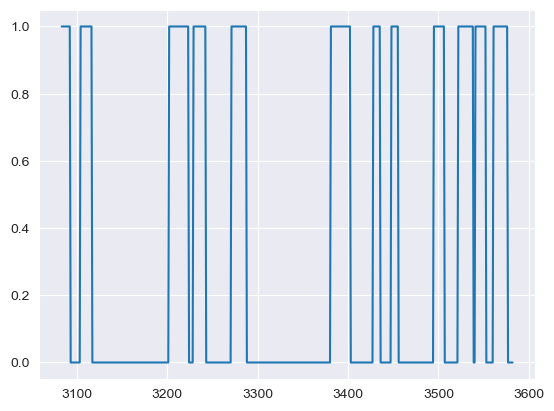

In [25]:
df_features['Fixation'][:500].plot()